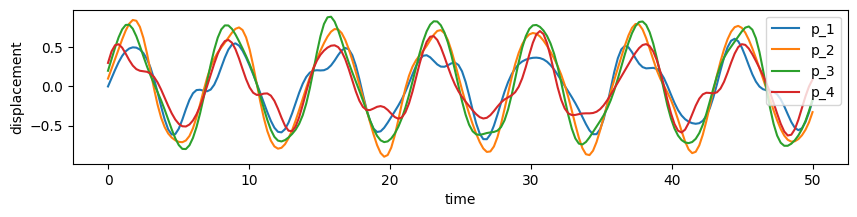

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# formulas can be found in https://scholar.harvard.edu/files/schwartz/files/lecture3-coupled-oscillators.pdf
k = 2
m = 1

dt = 0.25
M = 200

# full system dynamics
# after this code block, K is a 8 x 8 matrix modelling the flow of (p1,p2,p3,p4,dp1,dp2,dp3,dp4)
# with the above time discretization
K = 1/m * np.array([[-2*k, k, 0, 0], [k, -2*k, k, 0], [0, k, -2*k, k], [0, 0, k, -2*k]])
K = np.block([[np.zeros((4,4)), np.eye(4)], [K, np.zeros((4,4))]])
sigma, Q = np.linalg.eig(K)
K = Q @ np.diag(np.exp(sigma*dt)) @ np.linalg.inv(Q)

# initial state. y0[0,:] is (p1,p2,p3,p4); y0[1,:] is (dp1,dp2,dp3,dp4).
y0 = np.zeros((2,4)) 
y0[:,0] = [0,  0.4]
y0[:,1] = [0.1,0.5]
y0[:,2] = [0.2,0.6]
y0[:,3] = [0.3,0.7]
# simulate for M steps
xs = np.empty((M,2,4))
xs[0,:,:] = y0
for k in range(xs.shape[0]-1): 
    xs[k+1,:,:] = (K @ xs[k,:,:].flatten()).reshape(-1, 2, 4).real 

# plots trajectory
fig, ax = plt.subplots(1,1,figsize=(10,2))
time = np.linspace(0,dt*M,M)
ax.plot(time, xs[:,0,0], label="p_1")
ax.plot(time, xs[:,0,1], label="p_2")
ax.plot(time, xs[:,0,2], label="p_3")
ax.plot(time, xs[:,0,3], label="p_4")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("displacement")
plt.show()

In [2]:
# general group-theoretic operations, 
# implementation done for exposition

# the Cayley table of the reflection group
# (but this code works for one any other group too)
G            = [ "e", "a" ]
G_inv        = [ "e", "a" ]
cayley_table = """
    e a
    a e 
"""
cayley_table = [ line.split() for line in cayley_table.split("\n") ][1:-1]

def simplify(gstring):
    # takes a sequence of group elements, such as "eaaeaaeaaaa",
    # and reduces it to a single element (in this case "e").
    while len(gstring) > 1:
        g, h = gstring[-2:]
        ig, ih = G.index(g), G.index(h)
        gstring = gstring[:-2] + cayley_table[ig][ih]
    return gstring

def gidx(gstring):
    # returns the index position of a group element in the group, 
    # e.g. gidx("eaaa") = gidx("a") = 1, gidx("aa") = gidx("e") = 0.
    return G.index( simplify(gstring) )

def act(gstring, y):
    # y is a state of the form 2 x 4
    # the action as defined in the paper:
    # "a" : maps (p1,p2,p3,p4,dp1,dp2,dp3,dp4) to (p4,p3,p2,p1,dp4,dp3,dp2,dp1).
    # "e" : maps (p1,p2,p3,p4,dp1,dp2,dp3,dp4) to itself.
    g = simplify(gstring)
    if g[-1] == "a": y = np.flip(y, axis=-1)
    elif g[-1] == "e": y = y
    else: raise Exception()
    return y

def group_convolve(A, z):
    # A : G -> C^{S x S}
    # z : G -> C^{S}
    # returns a function : G -> C^S
    # ( inefficient way to compute group convolutions )
    return lambda g: sum( A(h) @ z( h_inv + g ) for (h, h_inv) in zip(G, G_inv))

def group_function_to_vector(c):
    # given a group function c: G -> C, returns a |G|-dimensional vector
    return np.stack( [ c(g) for g in G ], axis=-1 )


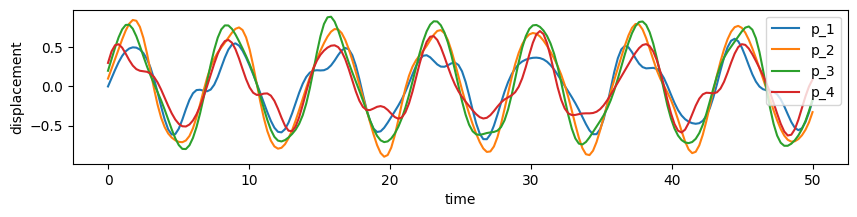

In [4]:
len_S = 4 # number of base observables

def chi(y):
    # base observables
    chi1 = y[0,0]
    chi2 = y[0,1]
    chi3 = y[1,0]
    chi4 = y[1,1]
    return np.stack((chi1, chi2, chi3, chi4), axis=0)

def psi(y):
    # returns a vector of size |S|*|G|
    return group_function_to_vector(lambda g: chi(act(g, y)))


# C switches from psi(y) to y, i.e. C @ y = psi(y). (With y,psi(y) in C^8)
C = np.array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
              [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
              [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])
# we have K_equiv @ psi(y) = psi( K @ y ).
K_equiv = np.linalg.inv(C) @ K @ C
K_SG_SG = K_equiv.reshape(len_S, len(G), len_S, len(G))

# extract row to convolution kernel
A = lambda h: K_SG_SG[:, gidx("e"), :, gidx(G_inv[gidx(h)])]

# simulate the trajectory using convolutions (instead of the full matrix!)
psi_X_pred = np.empty((M,len_S,len(G)))
psi_X_pred[0,:,:] = psi(y0)
for k in range(M-1):
    psi_X_k = lambda h: psi_X_pred[k,:,gidx(h)] # <- creates a group function from a vector
    psi_X_pred[k+1,:,:] = group_function_to_vector( group_convolve(A, psi_X_k) ).real # <- computes convolution
psi_X_pred = psi_X_pred.reshape(-1, len_S * len(G))
ps_pred = (psi_X_pred @ C.T).reshape(-1, 2, 4) # <- transforms psi(y) back to y

# plots trajectory
fig, ax = plt.subplots(1,1,figsize=(10,2))
time = np.linspace(0,dt*M,M)
ax.plot(time, ps_pred[:,0,0], label="p_1")
ax.plot(time, ps_pred[:,0,1], label="p_2")
ax.plot(time, ps_pred[:,0,2], label="p_3")
ax.plot(time, ps_pred[:,0,3], label="p_4")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("displacement")
plt.show()